# Minimalistic HHL linear solver

## Implementation in `qiskit`

`qiskit` has an implementation of the hhl algorithm.
It can be imported using:

In [1]:
from qiskit.algorithms.linear_solvers.hhl import HHL

## Minimal example

We'll begin by importing a couple of dependencies.

In [2]:
import numpy as np
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver

## Problem posing

We'll solve a simple linear system of the form:

$$
A \vec x = \vec b
$$

where:

$$
A =
\begin{bmatrix}
a & b \\
b & a
\end{bmatrix}
:
a = 1,
b = -\frac{1}{3}
$$

and

$$
\vec b = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$

This example is based on the [`qiskit` tutorials](https://qiskit.org/textbook/ch-applications/hhl_tutorial.html), which in turn is based on [this publication](https://arxiv.org/abs/2108.09004).

In [3]:
a = 1
b = -1/3
matrix = np.array([[a, b], [b, a]])
vector = np.array([1, 0])

### Classical solution

Keep in mind that during the encoding the vector will be normalized.
This means that the equivalent classical problem would be that of:

$$
A\vec x = \frac{\vec b}{\| \vec b\|} \equiv \hat b
$$

In [4]:
nvector = vector / np.linalg.norm(vector)
classical_solution = NumPyLinearSolver().solve(matrix, nvector)
print(classical_solution)

{   'circuit_results': None,
    'euclidean_norm': 1.1858541225631423,
    'observable': None,
    'state': array([1.125, 0.375])}


The solution is given by:

In [5]:
exact_solution = classical_solution.state
print(exact_solution)

[1.125 0.375]


We can check that the classical solution $\vec s$ is correct by evaluating ensuring that:

$$
A \vec s - \hat b = \vec 0
$$

In [6]:
assert np.max(np.matmul(matrix, classical_solution.state) - nvector) == 0.0

## HHL solution

The `HHL` method has a very similar interface to that of `NumPyLinearSolver`, but applied naively, it will return the circuit instead of the solution:

### Naive approach

In [7]:
naive_hhl_solution = HHL().solve(matrix, vector)

Printing the circuit may be a good idea:

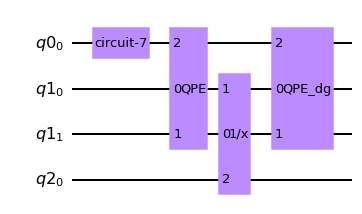

In [8]:
qc = naive_hhl_solution.state
qc.draw()

## Brute force approach

This is the only way I managed to make it work.
For a more details about how I reached this conclusions, please see the [exploratory analysis](./hhl_toymodel.ipynb).

## Simulate locally

We'll use `transpile` to rewrite our circuit exclusively in terms of basic gates:

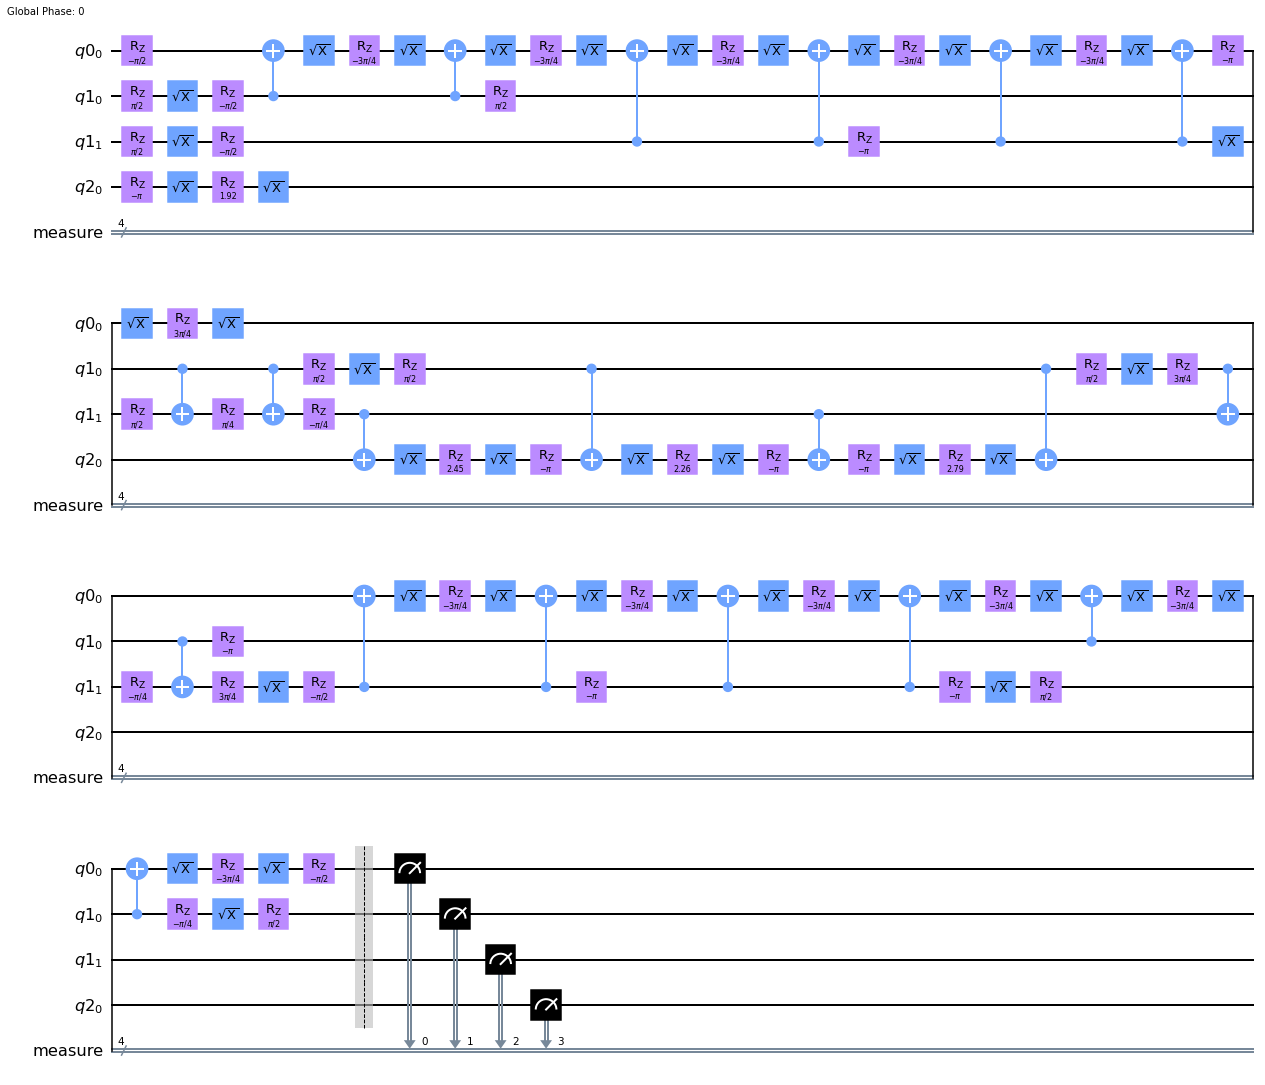

In [9]:
from qiskit import Aer, transpile
from qiskit.quantum_info import Operator

sim = Aer.get_backend('aer_simulator')
circ = transpile(qc, sim, basis_gates=['id', 'rz', 'sx', 'x', 'cx', 'reset'])

op = Operator(circ)

circ.measure_active()
circ.draw()

In [10]:
#from qiskit.quantum_info import Operator
#op = Operator(circ)
#print(op.data)

Now we can simulate the circuit.

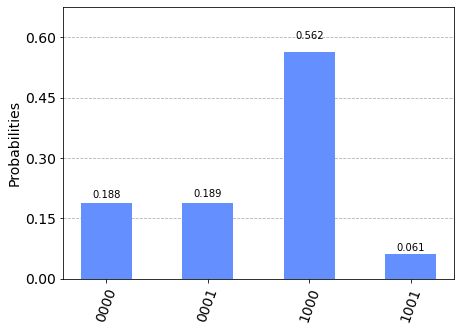

In [11]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

shots = 100000
result = sim.run(circ, shots=shots).result()
counts = result.get_counts()

plot_histogram(counts)

The solution is encoded in the coefficients of $\ket{1000}$ and $\ket{1001}$.
We can extract the absolute value of their coefficients by taking the square root of their measured probabilities.

In [12]:
def get_prob(key, counts=counts, shots=shots):
    """ Auxiliary function. Reads the probability of a given state"""
    return counts.get(key) / shots

def renormalization(counts=counts, shots=shots):
    """ Auxiliary renormalization function 
    
    Sums the probabilities of the only states we expect to be active.
    
    In a noise-free experiment (such as those in the simulators),
    we expect these probabilities to add up to 1.

    A more interesting situation happens with a real experiment,
    where noise can 'leak' to other states. The renormalization
    constant helps us getting cleaner results.
    """

    active_states = [get_prob("0000", counts, shots), 
                     get_prob("0001", counts, shots),
                     get_prob("1000", counts, shots),
                     get_prob("1001", counts, shots)]

    return np.sum(active_states)

probs = [get_prob("1000", counts, shots), # These are our only probabilities of interest
         get_prob("1001", counts, shots)] / renormalization(counts, shots)

unsignedcoefs = np.sqrt(probs)

print("Probabilities : ", probs)
print("Coefficients  : ", unsignedcoefs)

Probabilities :  [0.56202 0.06111]
Coefficients  :  [0.74967993 0.24720437]


### A note on renormalization

Notice that, in the simulation, only $4$ out of the $16$ states are active.
When we simulate this on a real quantum computer, some probability "leaks" to the other states.
In order to filter this, we can proceed as follows.

Imagine we have a state $\ket{\psi}$ composed of some expected and unexpected states ($\ket i$ and $\ket{e_j}$):

$$
\ket \psi \equiv \sum_i c_i \ket i + \sum_j \epsilon_j \ket{e_j}
$$

$\ket \psi$ is normalized, thus:

$$
|\braket{\psi, \psi}|^2 = \sum_i |c_i|^2 + \sum_j |\epsilon_j|^2 \equiv 1
$$

Now, if we brute-force filter the unexpected states, by making $\epsilon_j = 0$, we get a different state:

$$
\ket \phi \equiv \sum_i c_i \ket i 
$$

It is easy to see that the state $\ket \phi$ is not normalized:

$$
|\braket{\phi, \phi}|^2 = \sum_i |c_i|^2 = 1 - \sum_j |\epsilon_j|^2 \leq 1
$$

We can fix creating a new normalized state $\ket{\hat \psi}$:

$$
\ket{\hat \psi} \equiv \frac{1}{\sqrt{\sum_k |c_k|^2}} \ket \phi = \frac{1}{\sqrt{\sum_k |c_k|^2}} \sum_i c_i \ket i
$$

We claim that this renormalized state $\ket{\hat \psi}$ represents a solution after noise is filtered.
Its coefficients and probabilities are related with the direct experiment outputs by:

$$
\braket{j, \hat \psi} = \frac{c_j}{\sqrt{\sum_k |c_k|^2}}
$$

$$
|\braket{j, \hat \psi}|^2 = \frac{|c_j|^2}{\sum_k |c_k|^2}
$$

On an ideal (or a simulated) quantum computer, the renormalization should have no effect at all.

The ratio between both coordinates should remain constant in both the classical and quantum solvers.

In [13]:
print(unsignedcoefs[0] / unsignedcoefs[1])
print(exact_solution[0] / exact_solution[1])

3.0326322105875576
3.0000000000000004


## Simulate remotely

### Authenticate and login

In [14]:
# Your personal and confidential token
with open('token.txt') as f:
    ibmq_token = f.readlines()[0]
    # Write your personal token as the first line in token.txt, or hardcode it as ibmq_token = 'e34da...'

In [15]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

def get_ibmq_backend(token, # Your user token
                     hub='ibm-q-qal', # Which hub to use
                     group='escience', # Your working group's id
                     project='qradio', # Your project's id
                     id='', # Backend id. Leave empty for choosing the least busy
                     verbose=False):
    
    IBMQ.enable_account(ibmq_token)
    provider = IBMQ.get_provider(hub=hub, group=group, project=project)

    if len(id) > 0:
        backend = provider.get_backend(id)
    else:
        backend = least_busy(provider.backends())

    if verbose:
        print("Available backends: \n")
        for line in provider.backends():
            print(line)

    return backend

In [16]:
#backend_ibm = get_ibmq_backend(ibmq_token, id = 'ibmq_qasm_simulator', verbose = True) # Simulator
backend_ibm = get_ibmq_backend(ibmq_token, id = 'ibmq_guadalupe', verbose = True) # Production
backend_ibm.status()

Available backends: 

ibmq_qasm_simulator
ibmq_belem
ibmq_guadalupe
simulator_statevector
ibm_lagos
ibm_nairobi
ibm_perth
ibm_oslo


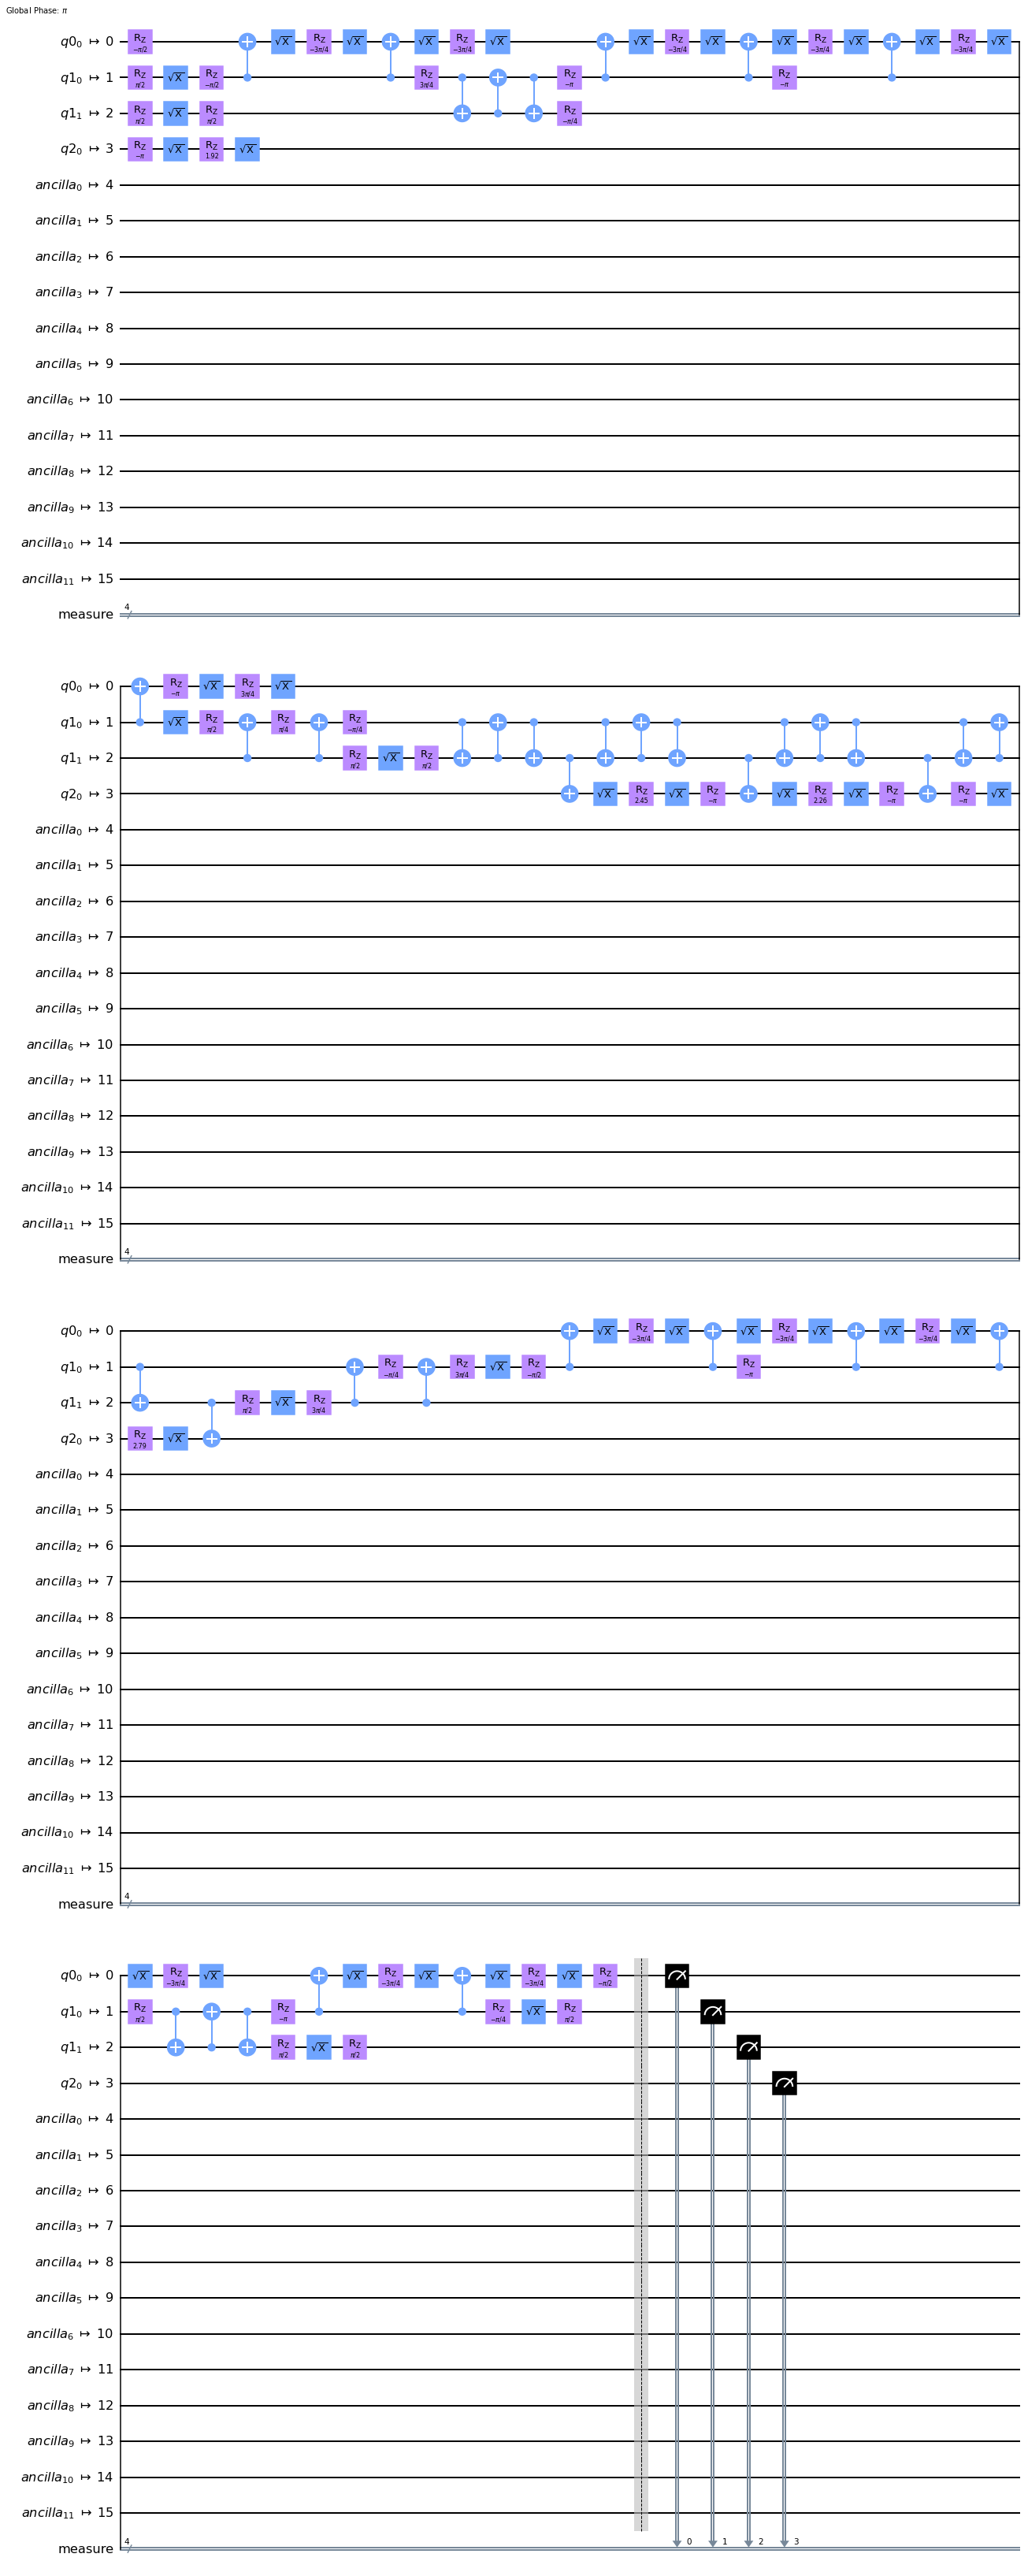

In [17]:
circ_ibm = transpile(qc, backend_ibm, basis_gates=['id', 'rz', 'sx', 'x', 'cx', 'reset']) # Transpile the circuit to the given backend

#op_ibm = Operator(circ_ibm)
circ_ibm.measure_active()
circ_ibm.draw()

The lines below perform the experiment.

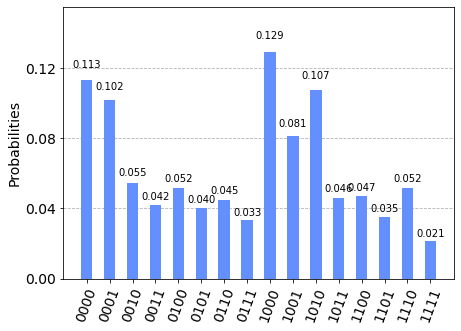

In [18]:
shots_ibm = 1024
result_ibm = backend_ibm.run(circ_ibm, shots=shots_ibm).result()
counts_ibm = result_ibm.get_counts()

plot_histogram(counts_ibm)

By the comparing the histogram above with the previous one, where only $4$ states were present, we realize that a lot of probability "leaks" to unexpected states.

We solved this problem using renormalization.

In [19]:
probs_ibm = [get_prob("1000", counts_ibm, shots_ibm), # These are our only probabilities of interest
             get_prob("1001", counts_ibm, shots_ibm)] / renormalization(counts_ibm, shots_ibm)

unsignedcoefs_ibm = np.sqrt(probs_ibm)

print("Probabilities : ", probs_ibm)
print("Coefficients  : ", unsignedcoefs_ibm)

Probabilities :  [0.19777861 0.12436079]
Coefficients  :  [0.44472307 0.35264826]


The ratio between both coordinates should remain constant in both the classical and quantum solvers.

In [20]:
print(unsignedcoefs_ibm[0] / unsignedcoefs_ibm[1])
print(exact_solution[0] / exact_solution[1])

1.2610953357233277
3.0000000000000004


## Perform some checks

Compare both the remote and local circuit matrices.

In [22]:
#assert op == op_ibm

0.6517704254566941